This notebook was made to predict the heights of high and low waters in New West, Mission by relating them to the corresponding higher high and lower low water at Point Atkinson and discharge at Hope.

In [1]:
from __future__ import division
from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from salishsea_tools.nowcast import figures
from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import glob
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import datetime
import arrow
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 426,
        'j' : 293
   
    },
    'Deas Island':{
        'lat' : 48.12,
        'lon' : -123.07,
        'i' : 414,
        'j' : 328
    },    
    'New Westminster': {
        'lat': 49.21,
        'lon': -122.89,
        'i': 418,
        'j': 365
        },

    'Mission': {
        'lat': 48.59,
        'lon': -123.2,
        'i':  500,
        'j':367
    },


        }

In [3]:
SITES = {
    'Point Atkinson': {
        'lat': 49.33,
        'lon': -123.25,
        'msl': 3.09,
        'stn_no': 7795,
        'extreme_ssh': 5.61},
    'Victoria': {
        'lat': 48.41,
        'lon': -123.36,
        'msl': 1.8810,
        'stn_no': 7120,
        'extreme_ssh': 3.76},
    'Campbell River': {
        'lat': 50.04,
        'lon': -125.24,
        'msl': 2.916,
        'stn_no': 8074,
        'extreme_ssh': 5.35},
    'Neah Bay': {
        'lat': 48.4,
        'lon': -124.6,
        'stn_no':  9443090},
    'Friday Harbor': {
        'lat': 48.55,
        'lon': -123.016667,
        'stn_no': 9449880},
    'Cherry Point': {
        'lat': 48.866667,
        'lon': -122.766667,
        'stn_no': 9449424},
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30},
    'Tofino': {
        'stn_no': 8615},
    }

In [4]:
grid_TT = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment\
/14days_norefraserxml/SalishSea_1h_20150616_20150629_grid_T.nc')

In [5]:
t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_TT)

In [6]:
def zoomin_period_tide(grid_T, stn_name, PST , MSL = 0):
    "Find out tide heights and time in PST or UTC \
     given a time series at stations we got our tidal predictions"
    time_shift = datetime.timedelta(hours=-8)
    t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_T)
    ttide = figures.get_tides(stn_name)
    time = ttide.time + PST * time_shift
    ssh = ttide.pred_all + SITES[stn_name]['msl'] * MSL
    ssh_zoom = []
    time_zoom = []
    for i in np.arange(len(ttide)):
        if (time[i].year == t_orig.year) & (time[i].month == t_orig.month)\
        & (time[i].day >= t_orig.day) & (time[i].day <= t_end.day):
            ssh_zoom.append(ssh[i])
            time_zoom.append(time[i])
    return ssh_zoom, time_zoom, t_orig, t_end

In [7]:
def find_highlow_tide(grid_T, ssh_zoom, time_zoom, t_end, t_orig, PST ):
    "Determine high and low tide heights in PST or UTC at\
    a given day at stations we got our tidal predictions, unit of \
    return ssh_max, ssh_min is feet rather than meter"
    ssh_max = []
    ssh_min = []
    time_max = []
    time_min = []
    j = 0
    for i in np.arange(t_end.day - t_orig.day +1):
        ssh_max.append(max(ssh_zoom[j:j+23])/0.3048)
        ssh_min.append(min(ssh_zoom[j:j+23])/0.3048)
        time_max.append(time_zoom[ssh_zoom.index(max(ssh_zoom[j:j+23]))])  
        time_min.append(time_zoom[ssh_zoom.index(min(ssh_zoom[j:j+23]))]) 
        j = j +24
    return ssh_max, ssh_min, time_max, time_min

In [8]:
ssh_zoom, time_zoom, t_orig, t_end = zoomin_period_tide(grid_TT,'Point Atkinson', 0, MSL = 0)
## I am not sure if MSL should be 0 or 1, does it really matter the relationship between PA and various
#stns water level...???

In [9]:
ssh_max,ssh_min,time_max,time_min=find_highlow_tide(grid_TT, ssh_zoom,time_zoom, t_end, t_orig, 0)

In [10]:
##combine both max and min tidal anomaly for Point Atkinson
ssh_obs = []
ssh_obs.append(ssh_max)
ssh_obs.append(ssh_min)

# SSH for various stns in model results

In [11]:
ssh_mod = grid_TT.variables['sossheig']
time_mod = grid_TT.variables['time_counter']
time_mod_array = time_mod[:]
time_mod_array = time_mod_array/3600-24

New Westminster

In [12]:
def readoff_stn_highlow_waterlevel(t_end, t_orig, jnd, ind, ssh_mod, time_mod):
    """This function was used to read through high and low water\
        levels at various stns during a time period, the water levels\
        returned are in feet unit instead of meters"""
    ssh_mod_max = []
    ssh_mod_min = []
    time_mod_max = []
    time_mod_min = []
    j = 0
    for i in np.arange(t_end.day - t_orig.day +1):
        ssh_mod_max.append(max(ssh_mod[j:j+23, jnd, ind])/0.3048)
        ssh_mod_min.append(min(ssh_mod[j:j+23, jnd, ind])/0.3048)
        time_mod_max.append(time_mod_array[j:j+23][np.argmax(ssh_mod[j:j+23, jnd, ind])])  
        time_mod_min.append(time_mod_array[j:j+23][np.argmin(ssh_mod[j:j+23, jnd, ind])]) 
        ## need to convert time_mod_min in hour to date!!
        j = j +24
    return ssh_mod_max, ssh_mod_min, time_mod_max, time_mod_min   

In [13]:
## grid cell for New Westminster is [418, 365]
ma, mi, tma, tmin = readoff_stn_highlow_waterlevel(t_end, t_orig, 418, 365,ssh_mod, time_mod)

In [14]:
##combine both max and min water level for NEW WESTMINSTER
ssh_model = []
ssh_model.append(ma)
ssh_model.append(mi)

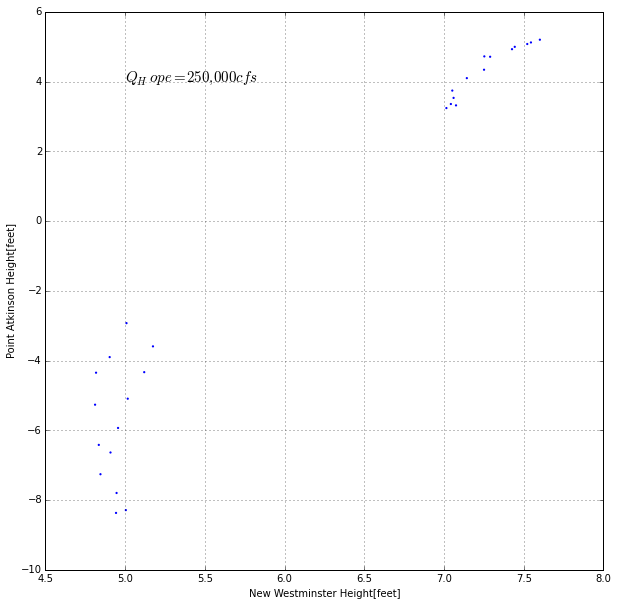

In [15]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.scatter(ssh_model,ssh_obs,color='blue',s=5,edgecolor='none')
plt.text(5, 4, r'$Q_Hope = 250,000cfs$', fontsize=15)
ax.grid()
ax.set_xlabel('New Westminster Height[feet]')
ax.set_ylabel('Point Atkinson Height[feet]')